# Cài đặt các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [3]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# Chuẩn hóa

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn feature

In [5]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

In [6]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [7]:
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

# Hàm bổ trợ

In [8]:
class RBFLayer:
    def __init__(self, centers, sigma=1.0):
        self.centers = centers
        self.sigma = sigma

    def compute(self, X):
        diff = X[:, np.newaxis, :] - self.centers
        dist_sq = np.sum(diff**2, axis=2)
        return np.exp(-dist_sq / (2 * self.sigma**2))

def softmax(z):
    # z: (n_samples, n_classes)
    z_max = np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z - z_max)
    return e_z / e_z.sum(axis=1, keepdims=True)

#Define PNN Model
class PNN:
    def __init__(self, sigma=1.0, batch_size=1000):
        self.sigma = sigma
        self.centers = None
        self.batch_size = batch_size

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        else:
            X_train = X_train
        if isinstance(y_train, pd.Series):
            y_train = y_train.values
        else:
            y_train = y_train

        classes = np.unique(y_train)
        centers = []
        for c in classes:
            centers.append(X_train[y_train == c].mean(axis=0))
        self.centers = np.vstack(centers)
        self.rbf = RBFLayer(self.centers, sigma=self.sigma)

    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        else:
            X = X
            
        n = X.shape[0]
        if self.batch_size is None:
            raw = self.rbf.compute(X)
            return softmax(raw)
        # batch processing
        probs = []
        for start in range(0, n, self.batch_size):
            end = min(start + self.batch_size, n)
            raw = self.rbf.compute(X[start:end])
            probs.append(softmax(raw))
        return np.vstack(probs)

    def predict(self, X):
        # trả về nhãn 0 hoặc 1
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

In [9]:
def train_and_evaluate_model(name, X_trval, y_trval, X_test, y_test, top_features=None, param_grid=None):
    print(f"\n=== Dataset: {name} ===")

    if top_features is not None:
        X_trval = X_trval[top_features]
        X_test = X_test[top_features]

    # Tách train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )

    best_sigma = 0.0
    best_score = 0.0

    print("Tuning sigma...")
    for sigma in param_grid['sigma']:
        pnn = PNN(sigma=sigma, batch_size=2048)
        pnn.fit(X_train, y_train)
        y_val_pred = pnn.predict(X_val)
        f1 = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)['macro avg']['f1-score']
        print(f" sigma={sigma:.3f} → val macro F1 = {f1:.4f}")

        if f1 > best_score:
            best_score = f1
            best_sigma = sigma

    print(f"⇒ Best sigma = {best_sigma}, validation macro F1 = {best_score:.4f}")

    # Huấn luyện lại với toàn bộ train+val
    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])

    pnn_final = PNN(sigma=best_sigma, batch_size=1000)
    pnn_final.fit(X_full, y_full)
    y_pred_test = pnn_final.predict(X_test)

    print("Test classification report:")
    print(classification_report(y_test, y_pred_test))
    cm = confusion_matrix(y_test, y_pred_test)
    print("Test confusion matrix:\n", cm)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title(f"{name} – sigma={best_sigma}")
    plt.show()

In [10]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_train, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 + 10 (All Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.4571
 sigma=0.012 → val macro F1 = 0.4571
 sigma=0.013 → val macro F1 = 0.4571
 sigma=0.015 → val macro F1 = 0.4571
 sigma=0.018 → val macro F1 = 0.4571
 sigma=0.020 → val macro F1 = 0.4571
 sigma=0.023 → val macro F1 = 0.4571
 sigma=0.027 → val macro F1 = 0.4571
 sigma=0.031 → val macro F1 = 0.4571
 sigma=0.036 → val macro F1 = 0.4571
 sigma=0.041 → val macro F1 = 0.4571
 sigma=0.047 → val macro F1 = 0.4571
 sigma=0.054 → val macro F1 = 0.4571
 sigma=0.063 → val macro F1 = 0.4571
 sigma=0.072 → val macro F1 = 0.4571
 sigma=0.083 → val macro F1 = 0.4571
 sigma=0.095 → val macro F1 = 0.4571
 sigma=0.110 → val macro F1 = 0.4571
 sigma=0.126 → val macro F1 = 0.4571
 sigma=0.146 → val macro F1 = 0.4571
 sigma=0.168 → val macro F1 = 0.4571
 sigma=0.193 → val macro F1 = 0.4571
 sigma=0.222 → val macro F1 = 0.4572
 sigma=0.256 → val macro F1 = 0.4587
 sigma=0.295 → val macro F1 = 0.4669
 sigma=0.339 

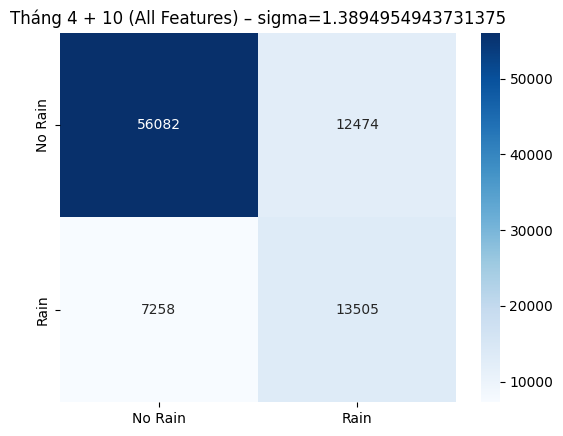


=== Dataset: Tháng 4 + 10 (Top Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.4571
 sigma=0.012 → val macro F1 = 0.4571
 sigma=0.013 → val macro F1 = 0.4571
 sigma=0.015 → val macro F1 = 0.4571
 sigma=0.018 → val macro F1 = 0.4571
 sigma=0.020 → val macro F1 = 0.4571
 sigma=0.023 → val macro F1 = 0.4571
 sigma=0.027 → val macro F1 = 0.4571
 sigma=0.031 → val macro F1 = 0.4571
 sigma=0.036 → val macro F1 = 0.4571
 sigma=0.041 → val macro F1 = 0.4571
 sigma=0.047 → val macro F1 = 0.4571
 sigma=0.054 → val macro F1 = 0.4571
 sigma=0.063 → val macro F1 = 0.4571
 sigma=0.072 → val macro F1 = 0.4571
 sigma=0.083 → val macro F1 = 0.4571
 sigma=0.095 → val macro F1 = 0.4571
 sigma=0.110 → val macro F1 = 0.4571
 sigma=0.126 → val macro F1 = 0.4571
 sigma=0.146 → val macro F1 = 0.4571
 sigma=0.168 → val macro F1 = 0.4572
 sigma=0.193 → val macro F1 = 0.4582
 sigma=0.222 → val macro F1 = 0.4607
 sigma=0.256 → val macro F1 = 0.4743
 sigma=0.295 → val macro F1 = 0.5010
 sigma=0.339 

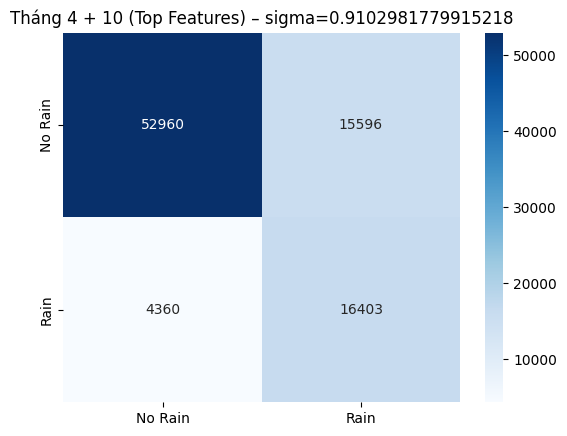

In [11]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    train_and_evaluate_model(f"{name} (All Features)", X_trval, y_trval, X_test, y_test, param_grid=param_grid)
    train_and_evaluate_model(f"{name} (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features, param_grid=param_grid)


# SMOTE

In [12]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

In [13]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [14]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_sm, X_test_scaled, y_test),
]


=== Dataset: Demo Dataset (All Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.3332
 sigma=0.012 → val macro F1 = 0.3332
 sigma=0.013 → val macro F1 = 0.3332
 sigma=0.015 → val macro F1 = 0.3332
 sigma=0.018 → val macro F1 = 0.3332
 sigma=0.020 → val macro F1 = 0.3332
 sigma=0.023 → val macro F1 = 0.3332
 sigma=0.027 → val macro F1 = 0.3332
 sigma=0.031 → val macro F1 = 0.3332
 sigma=0.036 → val macro F1 = 0.3332
 sigma=0.041 → val macro F1 = 0.3332
 sigma=0.047 → val macro F1 = 0.3332
 sigma=0.054 → val macro F1 = 0.3332
 sigma=0.063 → val macro F1 = 0.3332
 sigma=0.072 → val macro F1 = 0.3332
 sigma=0.083 → val macro F1 = 0.3332
 sigma=0.095 → val macro F1 = 0.3332
 sigma=0.110 → val macro F1 = 0.3332
 sigma=0.126 → val macro F1 = 0.3332
 sigma=0.146 → val macro F1 = 0.3333
 sigma=0.168 → val macro F1 = 0.3334
 sigma=0.193 → val macro F1 = 0.3344
 sigma=0.222 → val macro F1 = 0.3377
 sigma=0.256 → val macro F1 = 0.3480
 sigma=0.295 → val macro F1 = 0.3758
 sigma=0.339 

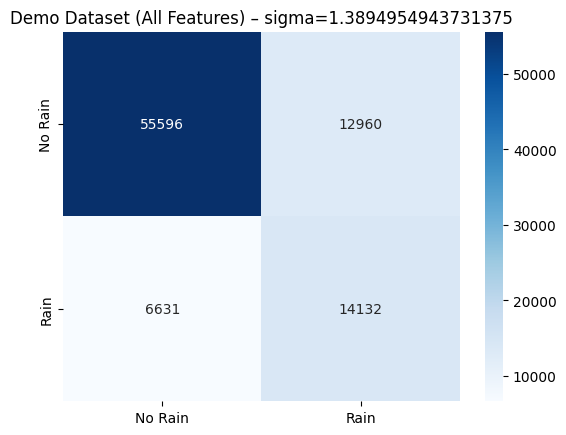


=== Dataset: Demo Dataset (Top Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.3332
 sigma=0.012 → val macro F1 = 0.3332
 sigma=0.013 → val macro F1 = 0.3332
 sigma=0.015 → val macro F1 = 0.3332
 sigma=0.018 → val macro F1 = 0.3332
 sigma=0.020 → val macro F1 = 0.3332
 sigma=0.023 → val macro F1 = 0.3332
 sigma=0.027 → val macro F1 = 0.3332
 sigma=0.031 → val macro F1 = 0.3332
 sigma=0.036 → val macro F1 = 0.3332
 sigma=0.041 → val macro F1 = 0.3332
 sigma=0.047 → val macro F1 = 0.3332
 sigma=0.054 → val macro F1 = 0.3332
 sigma=0.063 → val macro F1 = 0.3332
 sigma=0.072 → val macro F1 = 0.3332
 sigma=0.083 → val macro F1 = 0.3332
 sigma=0.095 → val macro F1 = 0.3333
 sigma=0.110 → val macro F1 = 0.3334
 sigma=0.126 → val macro F1 = 0.3337
 sigma=0.146 → val macro F1 = 0.3343
 sigma=0.168 → val macro F1 = 0.3375
 sigma=0.193 → val macro F1 = 0.3459
 sigma=0.222 → val macro F1 = 0.3654
 sigma=0.256 → val macro F1 = 0.4121
 sigma=0.295 → val macro F1 = 0.4828
 sigma=0.339 

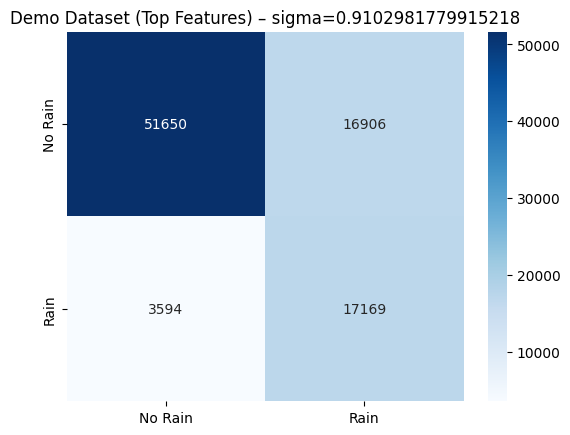

In [15]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    train_and_evaluate_model("Demo Dataset (All Features)", X_trval, y_trval, X_test, y_test, param_grid=param_grid)
    train_and_evaluate_model("Demo Dataset (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features, param_grid=param_grid)

# SMOTE ENN

In [16]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

In [17]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [18]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


=== Dataset: Demo Dataset (All Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.3320
 sigma=0.012 → val macro F1 = 0.3320
 sigma=0.013 → val macro F1 = 0.3320
 sigma=0.015 → val macro F1 = 0.3320
 sigma=0.018 → val macro F1 = 0.3320
 sigma=0.020 → val macro F1 = 0.3320
 sigma=0.023 → val macro F1 = 0.3320
 sigma=0.027 → val macro F1 = 0.3320
 sigma=0.031 → val macro F1 = 0.3320
 sigma=0.036 → val macro F1 = 0.3320
 sigma=0.041 → val macro F1 = 0.3320
 sigma=0.047 → val macro F1 = 0.3320
 sigma=0.054 → val macro F1 = 0.3320
 sigma=0.063 → val macro F1 = 0.3320
 sigma=0.072 → val macro F1 = 0.3320
 sigma=0.083 → val macro F1 = 0.3320
 sigma=0.095 → val macro F1 = 0.3320
 sigma=0.110 → val macro F1 = 0.3320
 sigma=0.126 → val macro F1 = 0.3320
 sigma=0.146 → val macro F1 = 0.3320
 sigma=0.168 → val macro F1 = 0.3323
 sigma=0.193 → val macro F1 = 0.3335
 sigma=0.222 → val macro F1 = 0.3380
 sigma=0.256 → val macro F1 = 0.3511
 sigma=0.295 → val macro F1 = 0.3862
 sigma=0.339 

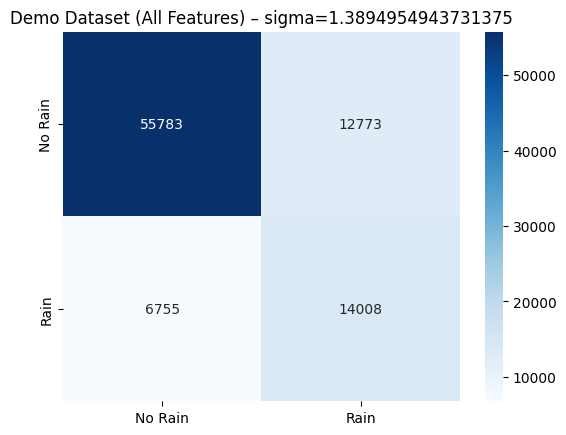


=== Dataset: Demo Dataset (Top Features) ===
Tuning sigma...
 sigma=0.010 → val macro F1 = 0.3320
 sigma=0.012 → val macro F1 = 0.3320
 sigma=0.013 → val macro F1 = 0.3320
 sigma=0.015 → val macro F1 = 0.3320
 sigma=0.018 → val macro F1 = 0.3320
 sigma=0.020 → val macro F1 = 0.3320
 sigma=0.023 → val macro F1 = 0.3320
 sigma=0.027 → val macro F1 = 0.3320
 sigma=0.031 → val macro F1 = 0.3320
 sigma=0.036 → val macro F1 = 0.3320
 sigma=0.041 → val macro F1 = 0.3320
 sigma=0.047 → val macro F1 = 0.3320
 sigma=0.054 → val macro F1 = 0.3320
 sigma=0.063 → val macro F1 = 0.3320
 sigma=0.072 → val macro F1 = 0.3320
 sigma=0.083 → val macro F1 = 0.3320
 sigma=0.095 → val macro F1 = 0.3320
 sigma=0.110 → val macro F1 = 0.3321
 sigma=0.126 → val macro F1 = 0.3323
 sigma=0.146 → val macro F1 = 0.3333
 sigma=0.168 → val macro F1 = 0.3369
 sigma=0.193 → val macro F1 = 0.3466
 sigma=0.222 → val macro F1 = 0.3708
 sigma=0.256 → val macro F1 = 0.4234
 sigma=0.295 → val macro F1 = 0.5091
 sigma=0.339 

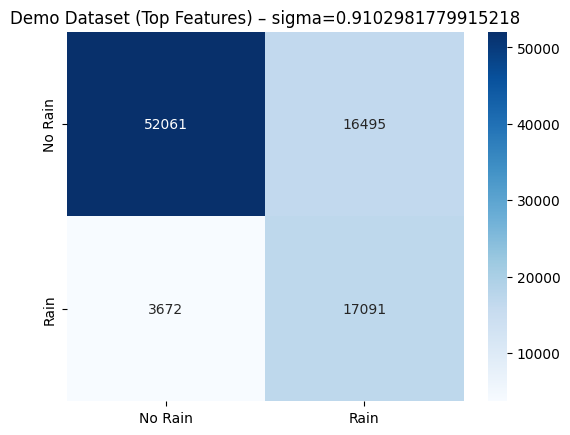

In [19]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    train_and_evaluate_model("Demo Dataset (All Features)", X_trval, y_trval, X_test, y_test, param_grid=param_grid)
    train_and_evaluate_model("Demo Dataset (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features, param_grid=param_grid) 